<a href="https://colab.research.google.com/github/Barryjuait/Barryjuait/blob/master/Dysk_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from __future__ import print_function
import os
import sys
import pandas as pd
import numpy as np
import random
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import datetime

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, Dense, Input, Dropout, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Flatten, AveragePooling1D, LeakyReLU, BatchNormalization, UpSampling1D, Reshape
from keras.optimizers import SGD
from keras.models import Model, Sequential, load_model
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical

import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler

from scipy import signal
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d, gaussian_filter

import scikitplot
from scikitplot.metrics import plot_confusion_matrix, plot_roc, plot_cumulative_gain, plot_precision_recall, plot_lift_curve
from sklearn.metrics import confusion_matrix, roc_curve, auc

import librosa

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [ ]:
#set current working directory
path = '/content/drive/MyDrive/Colab Notebooks/'
os.chdir(path)

In [ ]:
#Read the dataset into a pandas.DataFrame
Data = pd.read_csv(path + 'CollectedSpectra.csv')

In [ ]:
#Scale the data and update the dataframe:
faxis = np.arange(0, 150.5, 0.5);
scaler = MinMaxScaler();
dummy = Data.iloc[:, range(len(faxis))];
result = scaler.fit_transform(dummy.T)
Data.iloc[:, range(len(faxis))] = result.T;
Data.State[np.logical_and(Data.Drug == 4, Data.State > 1)] = np.nan;

##Descriptive Analysis:

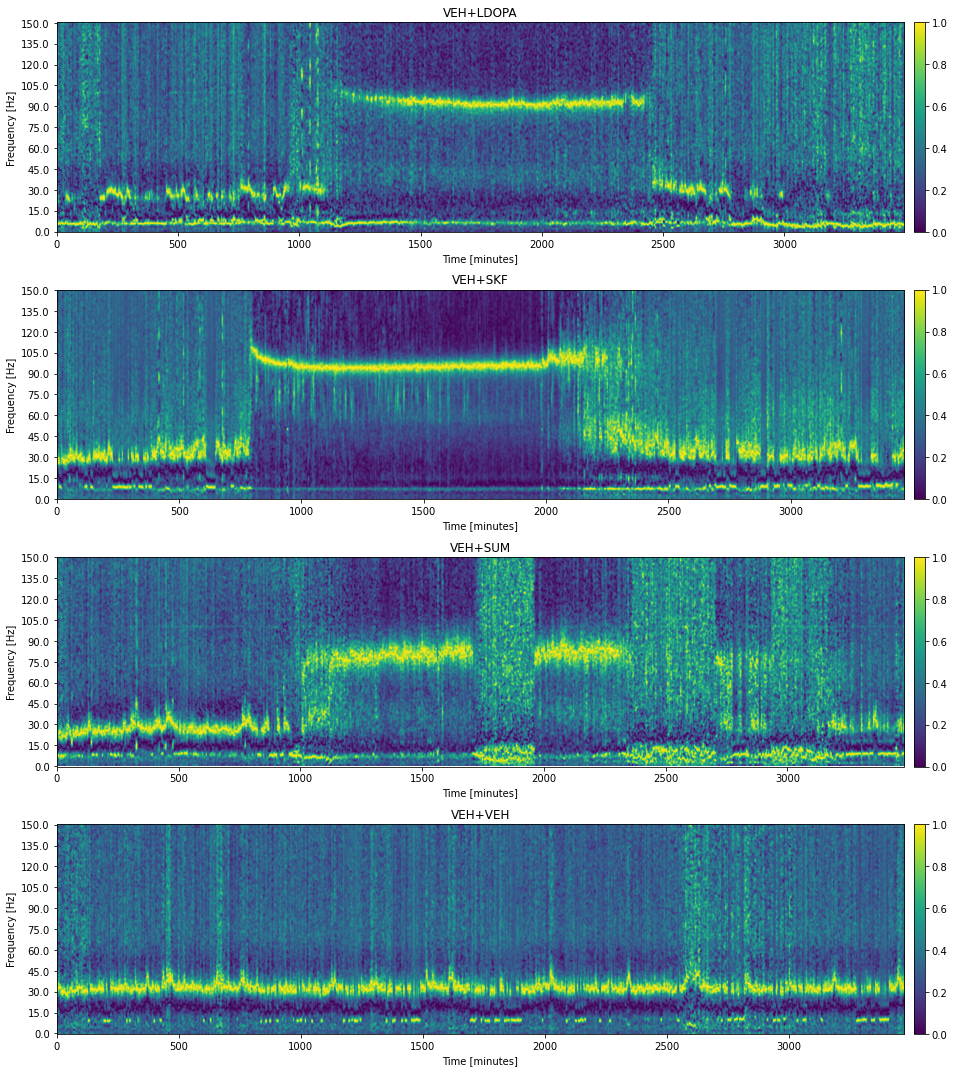

In [ ]:
#Plot Spectrograms per Drug:
bDrugs = ['VEH+LDOPA', 'VEH+SKF', 'VEH+SUM', 'VEH+VEH'];
faxis = np.arange(0, 150.5, 0.5);

fig, ax = plt.subplots(len(bDrugs),1, figsize = (15,15))
for k in range(len(bDrugs)):
  sel = np.logical_and(Data.Hemi == 2, Data.Drug == k+1)
  bSessions = np.unique(Data.Session[sel]);
  idx = random.randint(0,len(bSessions));
  sel = np.logical_and(sel, Data.Session == bSessions[idx]);

  spg = np.array(Data.iloc[:, range(len(faxis))]);
  spg = spg[sel,:].T
  btaxis = np.array(Data.taxis[sel]);  
  
  pcm = ax[k].imshow(spg, aspect = 'auto');
  ax[k].invert_yaxis();
  fig.colorbar(pcm, ax=ax[k], pad = 0.01)
  ax[k].set_xlabel('Time [minutes]');
  fslice = range(0,len(faxis),30);
  ax[k].set_yticks(fslice);
  ax[k].set_yticklabels(faxis[fslice]);
  ax[k].set_ylabel('Frequency [Hz]');
  ax[k].set_title(f'{bDrugs[k]}');

fig.tight_layout()
plt.show();

In [ ]:
def getStatesSpectra(Data):
  bDrugs = ['VEH+LDOPA', 'VEH+SKF', 'VEH+SUM', 'VEH+VEH'];
  faxis = np.arange(0, 150.5, 0.5);
  fig, ax = plt.subplots(1, len(bDrugs), figsize = (15,6), sharey = True);
  disc = np.logical_or(np.isnan(Data.State), np.in1d(Data.State, [-1, 4]));
  n_states = (np.unique(Data.State[~disc]));

  for j in range(len(n_states)):
    sel = np.logical_and(Data.Hemi == 2, ~disc);
    sel = np.logical_and(sel, Data.State == j);
    a = Data.iloc[list(sel), range(len(faxis))];
    #a = a[sel,:];
    a.columns = faxis;
    a['Drug'] = Data.Drug[sel];
    a = a.reset_index();

    melted = a.melt(id_vars= ['index', 'Drug'], var_name='faxis', value_name='power_spectra').sort_index('index')
    melted.rename(columns={'index':'bindex'}, inplace=True);
    melted.faxis = melted.faxis.astype('category');
    melted.sort_values('bindex', inplace = True);

    sns.lineplot(data = melted, x = 'faxis', y = 'power_spectra', hue = 'Drug', ax = ax[j])
    ax[j].set_xlabel('Frequency [Hz]')
    ax[j].set_ylabel('Scaled Power');
    ax[j].set_title(f'State {j}', fontsize = 14);
    ax[j].grid();

    x = np.unique(a.Drug.astype(int)) - 1; #getting the right drug indexes
    ax[j].legend([bDrugs[ix] for ix in x]); #slicing the list of drugs
  fig.tight_layout()
  plt.show();


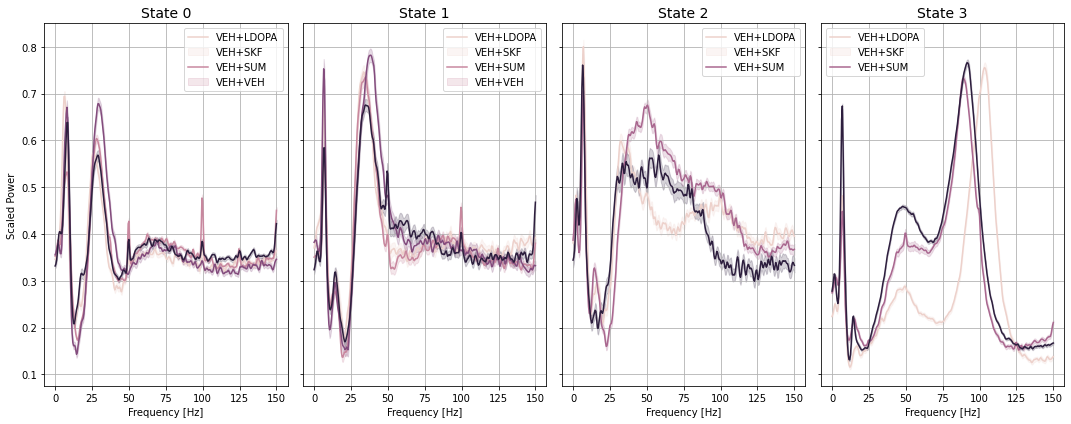

In [ ]:
#Plot Spectra per State per Drug:
getStatesSpectra(Data)

In [ ]:
#make a copy:
df = Data.copy();

#remove nans:
df.dropna(subset=['State'], axis=0, inplace=True);

#leave only right hemisphere:
df.drop(df[np.in1d(df['State'], [-1, 4])].index, inplace = True);
df.drop(df[df['Hemi'] == 1].index, inplace = True);

#update:
df.State = df.State;
df.reset_index(drop=True, inplace=True);

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
x0,22444.0,0.315036,0.135955,0.000000,0.219770,0.298359,0.390559,1.000000
x0_5,22444.0,0.321845,0.130647,0.000000,0.229271,0.304614,0.395101,0.962994
x1,22444.0,0.331596,0.125491,0.016792,0.242808,0.313996,0.401856,1.000000
x1_5,22444.0,0.344838,0.126257,0.000000,0.256214,0.325143,0.417144,1.000000
x2,22444.0,0.352693,0.135895,0.000000,0.257949,0.330226,0.425751,1.000000
...,...,...,...,...,...,...,...,...
Session,22444.0,179.055694,50.428449,73.000000,140.000000,179.000000,230.000000,250.000000
Drug,22444.0,2.312021,0.949181,1.000000,2.000000,2.000000,3.000000,4.000000
taxis,22444.0,59.241607,66.542978,-55.533333,4.570833,52.466667,116.854167,181.733333
Hemi,22444.0,2.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000


In [ ]:
def plotStateSpectra(X, y):
  n_states = len(np.unique(y))
  fig, ax = plt.subplots(1,n_states,figsize = (15,6), sharey = True);
  dummy = pd.DataFrame(X);
  faxis = np.arange(0, 150.5, 0.5);
  for ix in range(n_states):
    a = dummy.loc[y == ix,'0':'300'];
    a.columns = faxis;
    a = a.reset_index();

    melted = a.melt(id_vars='index', var_name='faxis', value_name='power_spectra').sort_index('index')
    melted.rename(columns={'index':'bindex'}, inplace=True);
    melted.faxis = melted.faxis.astype('category');
    melted.sort_values('bindex', inplace = True);

    sns.lineplot(data = melted, x = 'faxis', y = 'power_spectra', ax = ax[ix])
    ax[ix].set_xlabel('Frequency [Hz]')
    ax[ix].set_ylabel('Scaled Power');
    ax[ix].set_title(f'State {ix}', fontsize = 14);
    ax[ix].grid();
  plt.show();

In [ ]:
#Set X and y for the analysis:
faxis = np.arange(0, 150.5, 0.5);
X = np.array(df.iloc[:, range(len(faxis))]);
y = np.array(df.State.astype('category'));

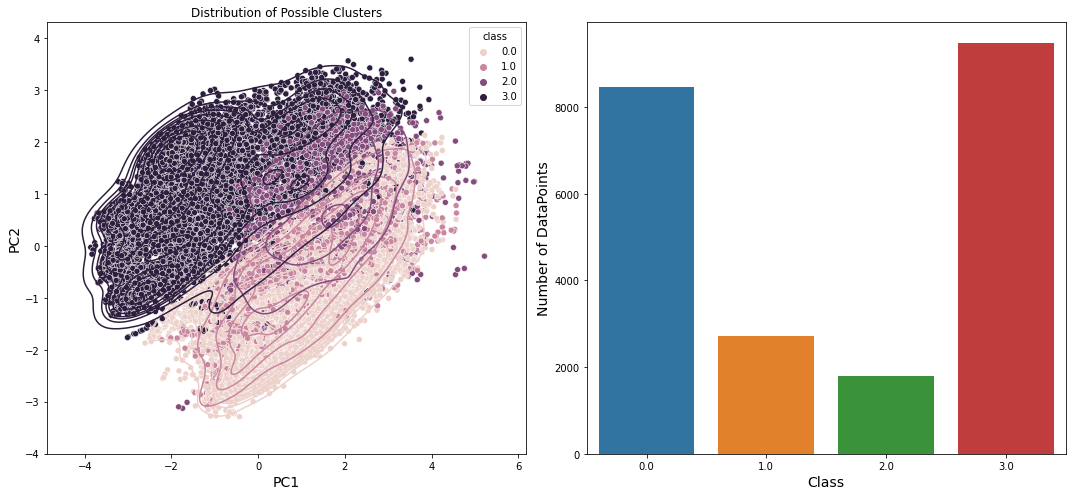

In [ ]:
#Check how does the data looks like:

# Initialize PCA
pca = PCA()

# Fit the PCA model to the data
pca.fit(X)

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components needed to explain at least 80% of the variance
n_components = np.argmax(cumulative_explained_variance >= 0.8) + 1

# Update the PCA model with the number of components needed to explain at least 80% of the variance
pca = PCA(n_components=n_components)
pca.fit(X)

# Perform dimensionality reduction on the data
X_reduced = pca.transform(X)

bdic = {'PC1': X_reduced[:,0], 'PC2': X_reduced[:,1], 'PC3': X_reduced[:,2], 'class': y};
dfPCA = pd.DataFrame.from_dict(bdic);

bdic = {'PC1': X_reduced[:,0], 'PC2': X_reduced[:,1], 'PC3': X_reduced[:,2], 'class': y};
dfPCA = pd.DataFrame.from_dict(bdic);

fig, ax = plt.subplots(1,2, figsize = (15,7));
#sns.jointplot(data = dfPCA, x = 'PC1', y = 'PC2', hue = 'class', kind = 'kde', ax = ax[0]);
sns.kdeplot(data = dfPCA, x = 'PC1', y = 'PC2', hue = 'class', ax = ax[0]);
sns.scatterplot(data = dfPCA, x = 'PC1', y = 'PC2', hue = 'class', ax = ax[0]);
ax[0].set_title('Distribution of Possible Clusters');
ax[0].set_xlabel('PC1', fontsize = 14);
ax[0].set_ylabel('PC2', fontsize = 14);

sns.countplot(data = dfPCA, x = 'class', ax = ax[1]);
ax[1].set_xlabel('Class', fontsize = 14);
ax[1].set_ylabel('Number of DataPoints', fontsize = 14);

plt.tight_layout();
plt.show()




/usr/local/lib/python3.8/dist-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.8/dist-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


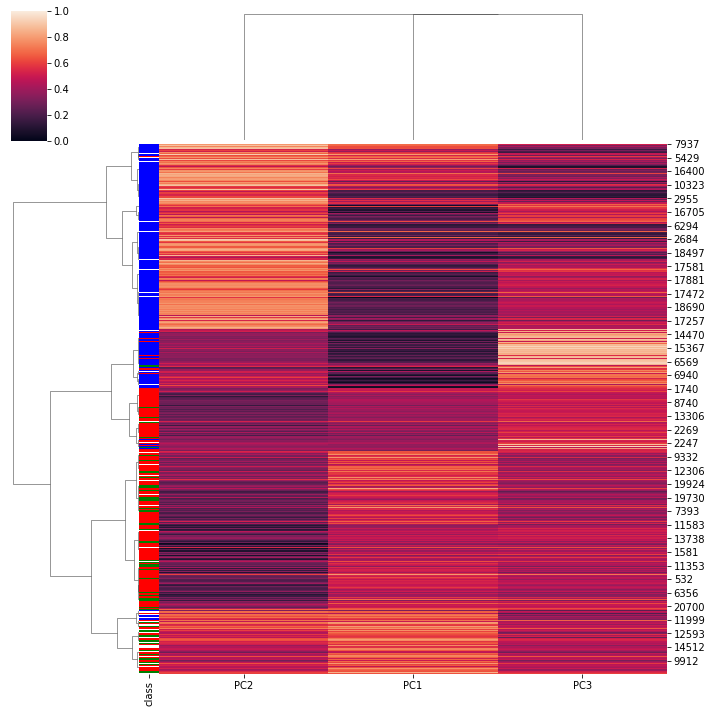

In [ ]:
dummy = dfPCA.copy();
classes = dummy.pop("class");
lut = dict(zip(classes.unique(), "rbg"));
row_colors = classes.map(lut);
sns.clustermap(dummy, row_colors=row_colors, standard_scale=1, metric = 'correlation')

## Predictive Model: 1D-CNN

https://towardsdatascience.com/types-of-convolution-kernels-simplified-f040cb307c37

###Model Design:

In [ ]:
def getModel(num_features, num_classes):
  # Define the model
  input_layer = Input(shape=(num_features,1), dtype = 'float32')
  conv_layer1 = Conv1D(filters=100, kernel_size= 3, activation='relu', padding = 'same')(input_layer)
  bn_layer1 = BatchNormalization()(conv_layer1)
  conv_layer2 = Conv1D(filters=100, kernel_size= 3, activation='relu', padding = 'same')(bn_layer1)
  bn_layer2 = BatchNormalization()(conv_layer2)
  pool_layer1 = MaxPooling1D(pool_size=3)(bn_layer2)
  conv_layer3 = Conv1D(filters=100, kernel_size= 3, activation='relu', padding = 'same')(pool_layer1)
  bn_layer3 = BatchNormalization()(conv_layer3)
  conv_layer4 = Conv1D(filters=100, kernel_size= 3, activation='relu', padding = 'same', strides=1)(bn_layer3)
  bn_layer4 = BatchNormalization()(conv_layer4)
  pool_layer2 = AveragePooling1D(pool_size=3)(bn_layer4)
  dropout_layer1 = Dropout(0.5)(pool_layer2)
  flatten_layer = Flatten()(dropout_layer1)
  dense1 = Dense(32, activation='relu')(flatten_layer)
  dense2 = Dense(16, activation='relu')(dense1)
  dense3 = Dense(8, activation='relu')(dense2)
  dropout_layer2 = Dropout(0.2)(dense3)
  output_layer = Dense(units=num_classes, activation='softmax')(dropout_layer2)

  # Compile the model
  model = Model(inputs=input_layer, outputs=output_layer)
  #model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  opt = keras.optimizers.Adam(learning_rate=0.0015); #learning rate
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  #model.summary()
  return model


##Data augmentation:

In [ ]:
import warnings

def scaleX(arr):
  # Scale the values between 0 and 1
  scaler2 = MinMaxScaler()
  arr = scaler2.fit_transform(arr.reshape(-1, 1)).flatten();
  return arr

def jitter(arr, sigma):
  noise = sigma * np.random.randn(len(arr))  # generate random Gaussian noise
  new_arr = arr + noise  # add noise to input signal

  return scaleX(new_arr)

def magnitude_warp2(arr, alpha):
  new_arr = arr * (1 + alpha * np.random.normal(size=arr.shape));
  return new_arr

def magnitude_warp(arr, alpha, chunk_size):
  if len(arr.shape) == 1:
    arr = arr.reshape(1, arr.shape[0])
    chunk_size = 10;
    alpha = 0.1;

  new_arr = np.zeros_like(arr)
  num_chunks = arr.shape[1] // chunk_size
  
  for i in range(arr.shape[0]):
      for j in range(num_chunks):
          idx = slice(j * chunk_size, (j + 1) * chunk_size)
          chunk = arr[i, idx]
          new_chunk = chunk * (1 + alpha * np.random.normal())
          new_arr[i, idx] = new_chunk

  if new_arr.shape[0] == 1:
    new_arr = new_arr.reshape(arr.shape[1])
  return scaleX(new_arr)

def time_stretch(arr, rate):
  with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Stretch the input signal
    stretched = librosa.effects.time_stretch(arr, rate)

  # Resample the output to the same length as the input
  resampled = signal.resample(stretched, len(arr))
  return scaleX(resampled)

def pitch_shift(arr, n_steps):
  with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Shift the pitch of the input signal
    shifted = librosa.effects.pitch_shift(arr, sr=22050, n_steps=n_steps)

  # Resample the output to the same length as the input
  resampled = signal.resample(shifted, len(arr))
  return scaleX(resampled)

def data_augmentation(data, y, sigma=0.1, alpha=0.2, chunk_size = 50, rate=0.2, n_steps=2):
  augmented_data = []
  new_y = []
  for i in range(data.shape[0]):
    arr = data[i, :]
    new_y.extend([y[i]] * 3)
    augmented_data.append(arr)
    augmented_data.append(jitter(arr, sigma))
    augmented_data.append(magnitude_warp(arr, alpha, chunk_size))
    #augmented_data.append(time_stretch(arr, 1+rate))
    #augmented_data.append(pitch_shift(arr, n_steps))
  return np.array(augmented_data), new_y

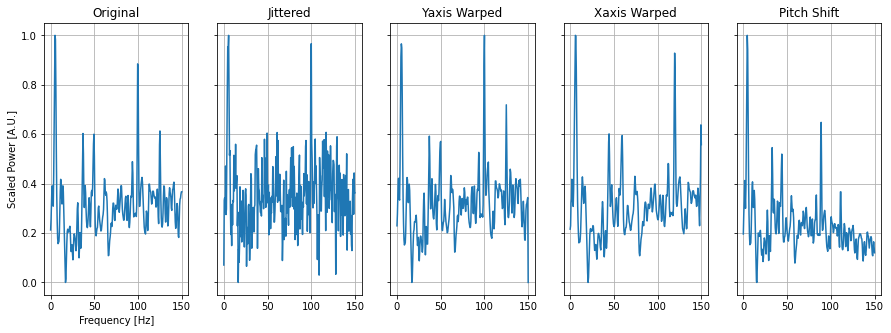

In [ ]:
#Example of what the custom-made data augmentation function is doing:
fig, ax = plt.subplots(1,5, figsize = (15,5), sharey = True);
idx = random.randint(0,len(X));

#USE DEFAULT VALUES:
chosen = X[idx,:];
ax[0].plot(faxis, chosen);
ax[0].set_xlabel('Frequency [Hz]');
ax[0].set_ylabel('Scaled Power [A.U.]');
ax[0].grid();
ax[0].set_title('Original');

ax[1].plot(faxis, jitter(chosen, 0.1));
ax[1].grid();
ax[1].set_title('Jittered');

ax[2].plot(faxis, magnitude_warp(chosen, 0.2, 50));
ax[2].grid();
ax[2].set_title('Yaxis Warped');

ax[3].plot(faxis, time_stretch(chosen, 1+0.2));
ax[3].grid();
ax[3].set_title('Xaxis Warped');

ax[4].plot(faxis, pitch_shift(chosen, 2));
ax[4].grid();
ax[4].set_title('Pitch Shift');
plt.show();

In [ ]:
# Train the model using 5-fold cross validation
xval = 5; #cross-validation rounds
nepochs = 60; #number of epochs
num_features = np.shape(X)[1];
bStates = np.unique(y);
num_classes = len(bStates);
kfold = StratifiedKFold(n_splits=xval, shuffle=True);

#save models on every iteration:
model_path = path + 'models';
save_weights_at = os.path.join(model_path, 'dysk.{epoch:02d}-{val_loss:.4f}.hdf5')
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min',
                            period=1);

scores = [];
lossx = [];
lossxval = [];
accx = [];
accxval = [];
  
#for train_index, test_index in kfold.split(X, y):
for ix in range(xval):

  print(f'\nValidation {ix+1}/{xval}')
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

  # Apply data augmentation to the training data
  print(f'\nData Augmentation')
  X_train, y_train = data_augmentation(X_train, y_train);

  # Convert the labels to categorical format
  y_train = keras.utils.to_categorical(y_train, num_classes=num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes=num_classes)

  print(f'\nTraining starts:')
  model = getModel(num_features, num_classes);
  history = model.fit(X_train, y_train, batch_size=32, epochs=nepochs, verbose=1, 
                      shuffle=True, callbacks=[save_best], validation_data=(X_test, y_test));

  # Collect training and validation loss/accuracy
  lossx.append(history.history['loss']);
  lossxval.append(history.history['val_loss']);
  accx.append(history.history['accuracy']);
  accxval.append(history.history['val_accuracy']);

  results = model.evaluate(X_test, y_test, verbose=0)

print("Accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(scores)*100, np.std(scores)*100))



Validation 1/5

Data Augmentation

Training starts:
Epoch 1/60
1410/1410 [==============================] - 54s 27ms/step - loss: 0.3723 - accuracy: 0.8478 - val_loss: 0.2229 - val_accuracy: 0.9144
Epoch 2/60
1410/1410 [==============================] - 40s 29ms/step - loss: 0.2626 - accuracy: 0.8948 - val_loss: 0.1809 - val_accuracy: 0.9309
Epoch 3/60
1410/1410 [==============================] - 31s 22ms/step - loss: 0.2244 - accuracy: 0.9127 - val_loss: 0.1801 - val_accuracy: 0.9371
Epoch 4/60
1410/1410 [==============================] - 34s 24ms/step - loss: 0.1926 - accuracy: 0.9259 - val_loss: 0.1355 - val_accuracy: 0.9452
Epoch 5/60
1410/1410 [==============================] - 38s 27ms/step - loss: 0.1664 - accuracy: 0.9347 - val_loss: 0.1204 - val_accuracy: 0.9588
Epoch 6/60
1410/1410 [==============================] - 36s 25ms/step - loss: 0.1579 - accuracy: 0.9406 - val_loss: 0.1082 - val_accuracy: 0.9567
Epoch 7/60
1410/1410 [==============================] - 36s 26ms/step -

###Performance of the Model:

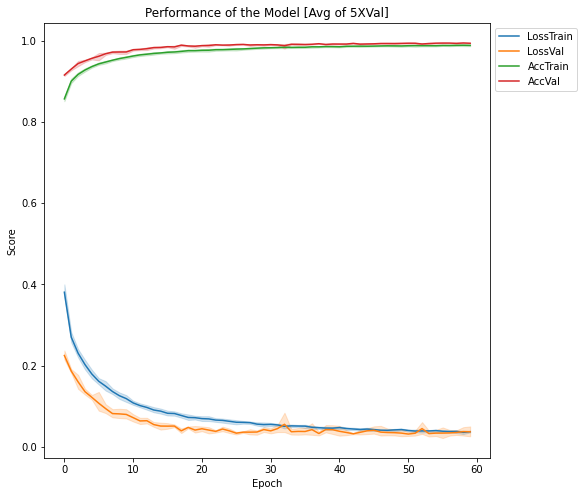

In [ ]:
# Create an empty dataframe
edf = pd.DataFrame(columns=['LossTrain', 'LossVal', 'AccTrain', 'AccVal', 'Epoch', 'XValRound'])

# Loop through the sublists and add their values to the dataframe
for ix in range(len(lossx)):
    sublists_df = pd.DataFrame({'LossTrain': lossx[ix], 'LossVal': lossxval[ix], 
                               'AccTrain': accx[ix], 'AccVal': accxval[ix], 
                               'Epoch': list(range(len(lossx[ix]))), 
                                'XValRound': [ix] * len(lossx[ix])});
    edf = edf.append(sublists_df, ignore_index=True)

# Reset the index of the dataframe
edf = edf.reset_index(drop=True);

#save model result:
os.makedirs(model_path, exist_ok=True)  
edf.to_csv(model_path +'/edf.csv');  


# Plot the training and validation loss:
fig, ax = plt.subplots(1,1, figsize = (8,8));
sns.lineplot(data = edf, x = 'Epoch', y = 'LossTrain', label = 'LossTrain', ax = ax);
sns.lineplot(data = edf, x = 'Epoch', y = 'LossVal', label = 'LossVal', ax = ax);
sns.lineplot(data = edf, x = 'Epoch', y = 'AccTrain', label = 'AccTrain', ax = ax);
sns.lineplot(data = edf, x = 'Epoch', y = 'AccVal', label = 'AccVal', ax = ax);
ax.set_ylabel('Score')
ax.set_xlabel('Epoch')
ax.set_title('Performance of the Model [Avg of 5XVal]')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1));
plt.show()

In [ ]:
# Get the index of the epoch with the lowest validation loss
min_loss_index = np.argmin(edf.LossVal);
best_val_loss = edf.LossVal[min_loss_index];
best_epoch = edf.Epoch[min_loss_index] + 1;
print(f'Best Validation Loss: {best_val_loss:.4f} at epoch {best_epoch}');

Best Validation Loss: 0.0193 at epoch 56


In [ ]:
best_model = load_model(os.path.join(model_path, f'dysk.{best_epoch:02d}-{best_val_loss:.4f}.hdf5'));

# Get the predicted probabilities
pred_probs = best_model.predict(X_test);

# The shape of pred_probs will be (number of test samples, number of classes)
print(pred_probs.shape)

# Each row represents the predicted probabilities for a single test sample
print(pred_probs[0])

232/232 [==============================] - 7s 24ms/step
(7407, 4)
[9.9997771e-01 2.2277221e-05 5.3511540e-10 1.9733891e-31]


In [ ]:
originalStates = np.argmax(y_test, axis = 1);
predStates = np.argmax(pred_probs, axis = 1)
print(f'Original States: {np.unique(originalStates)}');
print(f'Predicted States: {np.unique(predStates)}');

Original States: [0 1 2 3]
Predicted States: [0 1 2 3]


In [ ]:
mae = mean_absolute_error(originalStates, predStates)
print(f'MAE for the validation set: {mae:.4f}')

MAE for the validation set: 0.0062


In [ ]:
r2 = r2_score(predStates, originalStates)
print('R-squared for the validation set:', {r2:.4f})

R-squared for the validation set: 0.9958


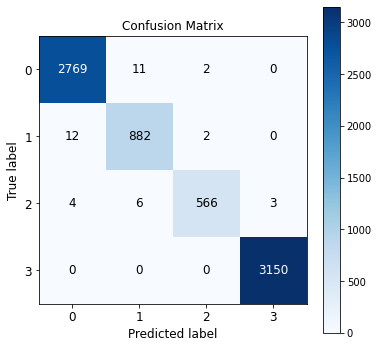

In [ ]:
# Plot the confusion matrix and the ROC curve in the same figure

# Plot the confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plot_confusion_matrix(originalStates, predStates, title = 'Confusion Matrix',text_fontsize = 'large', title_fontsize = 'large', ax = ax)
ax.set_title("Confusion Matrix")
plt.show()

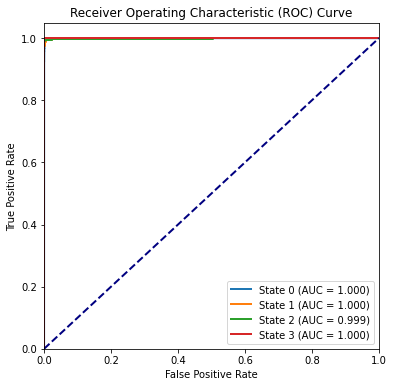

In [ ]:
# Plot the ROC curve
bStates = np.unique(originalStates);
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for k in range(len(bStates)):
  fpr, tpr, thresholds = roc_curve(originalStates == bStates[k], pred_probs[:,k]);
  roc_auc = auc(fpr, tpr)

  ax.plot(fpr, tpr, lw=2, label= f'State {bStates[k]} (AUC = {roc_auc:0.3f})')

ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (ROC) Curve')
ax.legend(loc="lower right")

plt.show()